# Set 1: Basics

This is the **qualifying set**.  We picked the exercises in it to ramp developers up gradually into coding cryptography, but also to verify that we were working with people who were ready to write code.

This set is **relatively easy**.  With one exception, most of these exercises should take only a couple minutes.  But don't beat yourself up if it takes longer than that.  It took Alex two weeks to get through the set!

If you've written any crypto code in the past, you're going to feel like skipping a lot of this.  Don't skip them.  At least two of them (we won't say which) are important stepping stones to later attacks.

- [Preliminaries](#Preliminaries)
- [Challenge 1: Convert hex to base64](#Challenge-1:-Convert-hex-to-base64)
- [Challenge 2: Fixed XOR](#Challenge-2:-Fixed-XOR)
- [Challenge 3: Single-byte XOR cipher](#Challenge-3:-Single-byte-XOR-cipher)
- [Challenge 4: Detect single-character XOR](#Challenge-4:-Detect-single-character-XOR)
- [Challenge 5: Implement repeating-key XOR](#Challenge-5:-Implement-repeating-key-XOR)
- [Challenge 6: Break repeating-key XOR](#Challenge-6:-Break-repeating-key-XOR)
- [Challenge 7: AES in ECB mode](#Challenge-7:-AES-in-ECB-mode)
- [Challenge 8: Detect AES in ECB mode](#Challenge-8:-Detect-AES-in-ECB-mode)

## Preliminaries

This notebook uses [pyca/cryptography](https://cryptography.io/en/latest/) (imported farther below).

In [1]:
import base64
from collections import Counter
from itertools import product
from math import prod

import pandas as pd
import matplotlib.pyplot as plt

## Challenge 1: Convert hex to base64

The string:

```
49276d206b696c6c696e6720796f757220627261696e206c696b65206120706f69736f6e6f7573206d757368726f6f6d
```

Should produce:

```
SSdtIGtpbGxpbmcgeW91ciBicmFpbiBsaWtlIGEgcG9pc29ub3VzIG11c2hyb29t
```

So go ahead and make that happen.  You'll need to use this code for the rest of the exercises.

> **Cryptopals Rule**
>
> Always operate on raw bytes, never on encoded strings.  Only use hex and base64 for pretty-printing.

In [2]:
input = "49276d206b696c6c696e6720796f757220627261696e206c696b65206120706f69736f6e6f7573206d757368726f6f6d"
output = base64.b64encode(bytes.fromhex(input))
print(output)

b'SSdtIGtpbGxpbmcgeW91ciBicmFpbiBsaWtlIGEgcG9pc29ub3VzIG11c2hyb29t'


## Challenge 2: Fixed XOR

Write a function that takes two equal-length buffers and produces their XOR combination.

If your function works properly, then when you feed it the string:

```
1c0111001f010100061a024b53535009181c
```

... after hex decoding, and when XOR'd against:

```
686974207468652062756c6c277320657965
```

... should produce:

```
746865206b696420646f6e277420706c6179
```

In [3]:
def xor(x, y):
    return bytes(xb^yb for xb, yb in zip(x, y))

x = bytes.fromhex("1c0111001f010100061a024b53535009181c")
y = bytes.fromhex("686974207468652062756c6c277320657965")

print(xor(x, y).hex())

746865206b696420646f6e277420706c6179


## Challenge 3: Single-byte XOR cipher

The hex encoded string:

```
1b37373331363f78151b7f2b783431333d78397828372d363c78373e783a393b3736
```

... has been XOR'd against a single character.  Find the key, decrypt the message.

You can do this by hand.  But don't: write code to do it for you.

How?  Devise some method for "scoring" a piece of English plaintext.  Character frequency is a good metric.  Evaluate each output and choose the one with the best score.

> **Achievement Unlocked**
>
> You now have our permission to make "ETAOIN SHRDLU" jokes on Twitter.

---

The English letter frequencies below were obtained from Peter Norvig's [English Letter Frequency Counts: Mayzner Revisited or ETAOIN SRHLDCU](http://www.norvig.com/mayzner.html), which is a slight revision of the classic ordering, [ETAOIN SHRDLU](https://en.wikipedia.org/wiki/Etaoin_shrdlu).  We score text using a probabilistic 1-gram model, that is, the score of a text is the product of the likelihoods of the individual characters.  (Ordinarily it would be necessary to switch from multiplying likelihoods to adding logarithms of likelihoods to avoid underflow, but this example is small enough that that is not necessary.)  To get frequencies for characters other than the 26 letters, we could use something fancy like [Witten-Bell smoothing](https://doi.org/10.1109/18.87000), but for the purpose here it is sufficient to assign an arbitrary low frequency to other characters that might plausibly appear, and 0 to characters that should never appear.

In [4]:
letter_frequencies = {
    "E": 0.1249,
    "T": 0.0928,
    "A": 0.0804,
    "O": 0.0764,
    "I": 0.0757,
    "N": 0.0723,
    "S": 0.0651,
    "R": 0.0628,
    "H": 0.0505,
    "L": 0.0407,
    "D": 0.0382,
    "C": 0.0334,
    "U": 0.0273,
    "M": 0.0251,
    "F": 0.0240,
    "P": 0.0214,
    "G": 0.0187,
    "W": 0.0168,
    "Y": 0.0166,
    "B": 0.0148,
    "V": 0.0105,
    "K": 0.0054,
    "X": 0.0023,
    "J": 0.0016,
    "Q": 0.0012,
    "Z": 0.0009
}

def score(ptext):
    def value(b):
        c = chr(b).upper()
        if c in letter_frequencies:
            return letter_frequencies[c]
        elif c.isprintable() or c in "\t\r\n":
            return min(letter_frequencies.values())
        else:
            return 0
    return prod(value(b) for b in ptext)

def brute_force_decrypt_xor(ctext):
    # Return the highest-scored plaintext and its score
    ptexts = [
        bytes(b^key for b in ctext)
        for key in range(256)
    ]
    return max(
        ({"plaintext": pt, "score": score(pt)} for pt in ptexts),
        key=lambda d: d["score"]
    )

ciphertext = bytes.fromhex("1b37373331363f78151b7f2b783431333d78397828372d363c78373e783a393b3736")
output = brute_force_decrypt_xor(ciphertext)
print(output["plaintext"])

b"Cooking MC's like a pound of bacon"


## Challenge 4: Detect single-character XOR

One of the 60-character strings in [this file](https://cryptopals.com/static/challenge-data/4.txt) has been encrypted by single-character XOR.

Find it.

(Your code from \#3 should help.)

In [5]:
print(
    max(
        (brute_force_decrypt_xor(bytes.fromhex(l.strip())) for l in open("04.in")),
        key=lambda d: d["score"]
    )["plaintext"]
)

b'Now that the party is jumping\n'


## Challenge 5: Implement repeating-key XOR

Here is the opening stanza of an important work of the English language:

> Burning 'em, if you ain't quick and nimble\
> I go crazy when I hear a cymbal

Encrypt it, under the key "ICE", using repeating-key XOR.

In repeating-key XOR, you'll sequentially apply each byte of the key; the first byte of plaintext will be XOR'd against I, the next C, the next E, then I again for the 4th byte, and so on.

It should come out to:

```
0b3637272a2b2e63622c2e69692a23693a2a3c6324202d623d63343c2a26226324272765272
a282b2f20430a652e2c652a3124333a653e2b2027630c692b20283165286326302e27282f
```

Encrypt a bunch of stuff using your repeating-key XOR function.  Encrypt your mail.  Encrypt your password file.  Your .sig file.  Get a feel for it.  I promise, we aren't wasting your time with this.

In [6]:
input = b"""Burning 'em, if you ain't quick and nimble
I go crazy when I hear a cymbal"""

key = b"ICE"

def encrypt_repeating_xor(ptext, key):
    return bytes(ptext[i]^key[i%len(key)] for i in range(len(ptext)))

print(encrypt_repeating_xor(input, key).hex())

0b3637272a2b2e63622c2e69692a23693a2a3c6324202d623d63343c2a26226324272765272a282b2f20430a652e2c652a3124333a653e2b2027630c692b20283165286326302e27282f


## Challenge 6: Break repeating-key XOR

> **It is officially on, now.**
>
> This challenge isn't conceptually hard, but it involves actual error-prone coding.  The other challenges in this set are there to bring you up to speed.  This one is there to qualify you.  If you can do this one, you're probably just fine up to Set 6.

[There's a file here](https://cryptopals.com/static/challenge-data/6.txt).  It's been base64'd after being encrypted with repeating-key XOR.

Decrypt it.

Here's how:

1. Let KEYSIZE be the guessed length of the key; try values from 2 to (say) 40.

2. Write a function to compute the edit distance/Hamming distance between two strings.  _The Hamming distance is just the number of differing bits._  The distance between:

   `this is a test`

   and

   `wokka wokka!!!`

   is 37.  _Make sure your code agrees before you proceed._

3. For each KEYSIZE, take the first KEYSIZE worth of bytes, and the second KEYSIZE worth of bytes, and find the edit distance between them.  Normalize this result by dividing by KEYSIZE.

4. The KEYSIZE with the smallest normalized edit distance is probably the key.  You could proceed perhaps with the smallest 2-3 KEYSIZE values.  Or take 4 KEYSIZE blocks instead of 2 and average the distances.

5. Now that you probably know the KEYSIZE: break the ciphertext into blocks of KEYSIZE length.

6. Now transpose the blocks: make a block that is the first byte of every block, and a block that is the second byte of every block, and so on.

7. Solve each block as if it was single-character XOR.  You already have code to do this.

8. For each block, the single-byte XOR key that produces the best looking histogram is the repeating-key XOR key byte for that block.  Put them together and you have the key.

This code is going to turn out to be surprisingly useful later on.  Breaking repeating-key XOR ("Vigenère") statistically is obviously an academic exercise, a "Crypto 101" thing.  But more people "know how" to break it than can actually break it, and a similar technique breaks something much more important.

> **No, that's not a mistake.**
>
> We get more tech support questions for this challenge than any of the other ones.  We promise, there aren't any blatant errors in this text.  In particular: the "wokka wokka!!!" edit distance really is 37.

---

The method for finding KEYSIZE is interesting.  It seems to rely on two properties.  First—and this comes as a surprise to us—the Hamming distance between likely bytes such as alphabetic letters is, on average, less than the distance between random bytes.  We can see this for ourselves as follows:

In [7]:
def hamming_distance(x, y):
    return sum((xb^yb).bit_count() for xb, yb in zip(x, y))

d = sum(
    (
        hamming_distance(bytes(x, encoding="ASCII"), bytes(y, encoding="ASCII"))
        * letter_frequencies[x]
        * letter_frequencies[y]
    )
    for x, y in product(letter_frequencies.keys(), repeat=2)
)
print("Weighted average edit distance between letters:", round(d, 1))

d = sum(
    hamming_distance(bytes([x]), bytes([y]))/256**2
    for x, y in product(range(256), repeat=2)
)
print("Average edit distance between random bytes:", round(d, 1))

Weighted average edit distance between letters: 2.4
Average edit distance between random bytes: 4.0


Second, Hamming distance is invariant under XOR with a constant, that is, if $C_1 = P_1 \oplus K$ and $C_2 = P_2 \oplus K$, then $dist(C_1, C_2) = dist(P_1, P_2)$.  This accounts for why, with the correct KEYSIZE, the distance between corresponding ciphertext bytes in different blocks (= distance between corresponding plaintext bytes) will likely be smaller.

However, as suggested by the problem statement, this is not foolproof.  Indeed, our solution finds the correct size (KEYSIZE=29) only by averaging the normalized distances over a window of 10 blocks; there are several other sizes that have similarly small distances.  The plot below shows distance as a function of KEYSIZE for window sizes of 2, 3, 5, and 10 blocks.

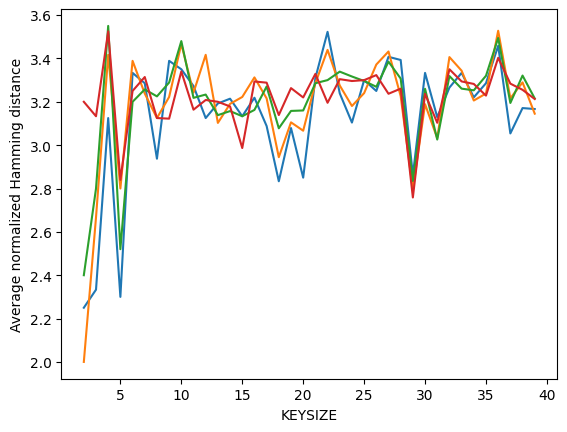

In [8]:
ciphertext = base64.b64decode(open("06.in").read())

def distance(ks, window):
    # Return the average normalized distance for a proposed KEYSIZE over a window of blocks
    return sum(
        hamming_distance(ciphertext[i*ks:(i+1)*ks], ciphertext[(i+1)*ks:(i+2)*ks]) / ks
        for i in range(window)
    ) / window

keysize_range = range(2, 40)
df = pd.DataFrame(index=keysize_range)

for window in [2, 3, 5, 10]:
    df[f"w{window}"] = [distance(ks, window) for ks in df.index]

for col in df.columns:
    plt.plot(df[col])
plt.xlabel("KEYSIZE")
plt.ylabel("Average normalized Hamming distance")
plt.show()

Now for our solution:

In [9]:
# Find probable KEYSIZE

ks = min((distance(ks, 10), ks) for ks in keysize_range)[1]

# If we think of blocks as rows, decrypt columns

cols = []

for i in range(ks):  # for each column
    nrows = (len(ciphertext)-1)//ks+1
    if (nrows-1)*ks+i+1 > len(ciphertext):  # handle ragged last row
        nrows -= 1
    col_ctext = bytes(ciphertext[j*ks+i] for j in range(nrows))
    cols.append(brute_force_decrypt_xor(col_ctext)["plaintext"])

# Transpose and output

plaintext = bytes(
    cols[i][j]
    for j in range(len(cols[0]))
    for i in range(len(cols))
    if j < len(cols[i])
)

print(plaintext.decode("ASCII").strip())

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 


## Challenge 7: AES in ECB mode

The Base64-encoded content [in this file](https://cryptopals.com/static/challenge-data/7.txt) has been encrypted via AES-128 in ECB mode under the key

```
"YELLOW SUBMARINE"
```

(case-sensitive, without the quotes; exactly 16 characters; I like "YELLOW SUBMARINE" because it's exactly 16 bytes long, and now you do too).

Decrypt it.  You know the key, after all.

Easiest way: use OpenSSL::Cipher and give it AES-128-ECB as the cipher.

> **Do this with code.**
>
> You can obviously decrypt this using the OpenSSL command-line tool, but we're having you get ECB working in code for a reason.  You'll need it a lot later on, and not just for attacking ECB.

---

The plaintext contains 4 bytes of PKCS#7 padding, which we remove.

In [10]:
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

decryptor = Cipher(algorithms.AES128(b"YELLOW SUBMARINE"), modes.ECB()).decryptor()
unpadder = padding.PKCS7(128).unpadder()

input = base64.b64decode(open("07.in").read())
output = unpadder.update(decryptor.update(input) + decryptor.finalize()) + unpadder.finalize()

print(output.decode("ASCII").strip())

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 


## Challenge 8: Detect AES in ECB mode

[In this file](https://cryptopals.com/static/challenge-data/8.txt) are a bunch of hex-encoded ciphertexts.

One of them has been encrypted with ECB.

Detect it.

Remember that the problem with ECB is that it is stateless and deterministic; the same 16 byte plaintext block will always produce the same 16 byte ciphertext.

---

It's not entirely clear what this challenge is asking for.  Surely we're not being asked to decrypt AES-encrypted texts as we did with simple XOR encryption above.  Looking around, other solvers seemed to interpret this as simply looking for the ciphertext with the most repeated blocks.  And indeed there is exactly one ciphertext that has repeated blocks.

In [11]:
def num_unique_blocks(ctext):
    assert len(ctext)%16 == 0
    return len(set(ctext[i:i+16] for i in range(0, len(ctext), 16)))

print(Counter(num_unique_blocks(bytes.fromhex(l.strip())) for l in open("08.in")))

Counter({10: 203, 7: 1})
